In [3]:
import numpy as np
np.random.seed(203)
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set(style="whitegrid")
from google.colab import files
from collections import Counter

from datetime import datetime

from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, KBinsDiscretizer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.linear_model import  LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers

In [4]:
def quantile_label(quantile_split, feature_values, duplicates=False):
#Function to define the lower & upper limits after pd.qcut (quantile cut)
#applicable for numeric (continue) feature
#INPUT : 
#quantile_split: list of intervals of split; for example quantile_split = [0, 0.25, 0.5, 0.75, 1]
#feature_values : all values of the feature to split (for example : feature_values = df['age'])

#duplicates : if there is one duplicate in qantile cut, the bins numbre reduce to len(quantile_split) - 2
#else : no duplicate : n_bins = len(quantile_split)-1


    feature_quantile = feature_values.quantile(quantile_split)
        #lower_limit = quantile_split[i]
        #upper_limit = quantile_split[i+1]
        #print(str(int(feature_quantile[lower_limit])) + '_' + str(int(feature_quantile[upper_limit])))
    if duplicates==True:
      return [f'{int(feature_quantile[quantile_split[i]])}_{int(feature_quantile[quantile_split[i+1]])}' for i in range(len(quantile_split)-2)]
    else:
      return [f'{int(feature_quantile[quantile_split[i]])}_{int(feature_quantile[quantile_split[i+1]])}' for i in range(len(quantile_split)-1)]

In [5]:
def quantile_split(n_bins, feature, duplicates='raise'):
    split = np.linspace(0,1,n_bins+1)
    feature_split = feature.quantile(split)

    if duplicates == 'drop':
        labels = [f'{round(feature_split[split[i]])}_{round(feature_split[split[i+1]])}' for i in range(n_bins-1)]
    else:
        labels = [f'{round(feature_split[split[i]])}_{round(feature_split[split[i+1]])}' for i in range(n_bins)]

    feature_quantile = pd.qcut(feature, q=split, duplicates='drop', labels=labels)

    return feature_quantile

In [ ]:
uploaded = files.upload()

Saving Fraud_Data.csv to Fraud_Data.csv
Saving IpAddress_to_Country.csv to IpAddress_to_Country.csv


In [6]:
df_country = pd.read_csv('/content/IpAddress_to_Country.csv')
df_country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [7]:
df = pd.read_csv('/content/Fraud_Data.csv')
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


#Merge 2 datasets by ip_address

In [8]:
idx = pd.IntervalIndex.from_arrays(df_country['lower_bound_ip_address'], df_country['upper_bound_ip_address'], closed='both')
country = df_country.iloc[idx.get_indexer(df['ip_address'])]['country']

df['country'] = country.values
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Australia
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [9]:
df.isnull().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
country           0
dtype: int64

Country : 
* count_country : total count of purchases
* category_country : qcut by using quantile (0, 0.25, 0.5, 0.75, 1)

In [10]:
df['count_country'] = df['country'].map(df['country'].value_counts())
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,count_country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,7306
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,58049
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,58049
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Australia,23810
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,58049


In [11]:
df['category_country'] = quantile_split(n_bins=5, feature=df['count_country'], duplicates='drop')

In [12]:
df['category_country'].value_counts()

23810_58049    58049
2961_12038     37778
1_2961         31475
12038_23810    23810
Name: category_country, dtype: int64

In [13]:
df.loc[df['class']==1]['ip_address'].value_counts()

3.484934e+08    19
3.874758e+09    19
2.050964e+09    19
1.502818e+09    19
5.760609e+08    19
                ..
2.337532e+09     1
1.477500e+09     1
2.618542e+09     1
3.816468e+09     1
3.451155e+09     1
Name: ip_address, Length: 7277, dtype: int64

In [14]:
df['count_ip'] = df['ip_address'].map(df['ip_address'].value_counts())
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,count_country,category_country,count_ip
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,7306,2961_12038,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,58049,23810_58049,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,58049,23810_58049,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Australia,23810,12038_23810,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,58049,23810_58049,1


In [ ]:
#df['count_ip_fraud'] = df['ip_address'].map(df.loc[df['class']==1]['ip_address'].value_counts())
#df['count_ip_fraud'] = df['count_ip_fraud'].fillna(0)

In [ ]:
#df['count_user_fraud'] = df['user_id'].map(df[df['class']==1]['user_id'].value_counts())
#df['count_user_fraud'] = df['count_user_fraud'].fillna(0)

In [ ]:
#df['count_deviceId_fraud'] = df['device_id'].map(df[df['class']==1]['device_id'].value_counts())
#df['count_deviceId_fraud'] = df['count_deviceId_fraud'].fillna(0)

Split count_country into 4 intervals, as a function of number of purchases

#Transform signup_time, purchase_time to datetime

Define online-time based on sigup_time and purchase_time

In [20]:
df[['signup_time', 'purchase_time']] = df[['signup_time', 'purchase_time']].apply(pd.to_datetime, errors='coerce')
df['online_time'] = (df['purchase_time'] - df['signup_time'])
df['online_time'] = df['online_time'].astype('timedelta64[m]')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


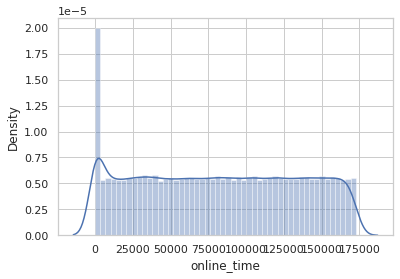

In [21]:
sns.distplot(df['online_time'])

In [ ]:
'''
df.loc[df.online_time == 0, 'category_time'] = 0
df.loc[df.online_time > 0, 'category_time'] = pd.qcut(df[df.online_time>0]['online_time'],
                                                       q=quantile_split,
                                                       labels=quantile_label(quantile_split, df[df.online_time>0]['online_time'], duplicates=False))
df['category_time'] = df['category_time'].astype('str')
df.head()
'''

#Visualization

In [16]:
df['class'].value_counts()/df['class'].shape[0]

0    0.906354
1    0.093646
Name: class, dtype: float64

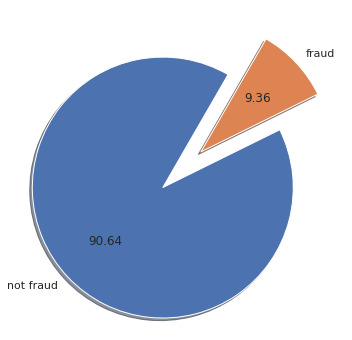

In [17]:
plt.figure(figsize=(6,6))
plt.pie(df['class'].value_counts()/df['class'].shape[0], explode=(0.2,0.2), 
        shadow=True, autopct='%.2f', startangle=60, labels=['not fraud', 'fraud'])
plt.rc('font', size=23)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

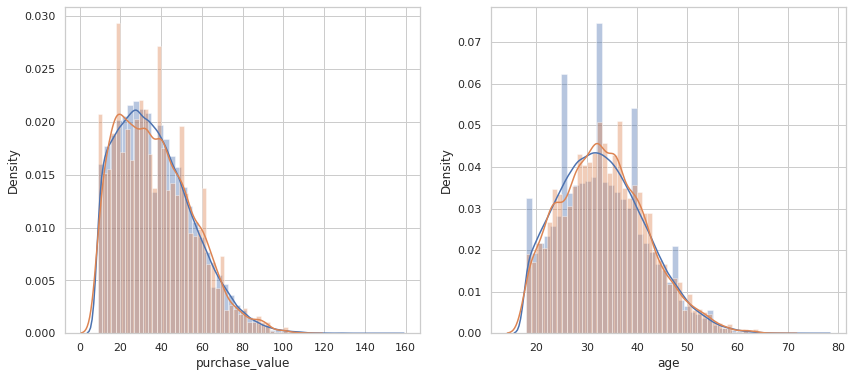

In [18]:
plt.figure(figsize=(14,6))
plt.subplot(121)
sns.distplot((df[(df['class']==0)]['purchase_value']))
sns.distplot((df[(df['class']==1)]['purchase_value']))

plt.subplot(122)
sns.distplot(df[(df['class']==0)]['age'])
sns.distplot(df[(df['class']==1)]['age'])

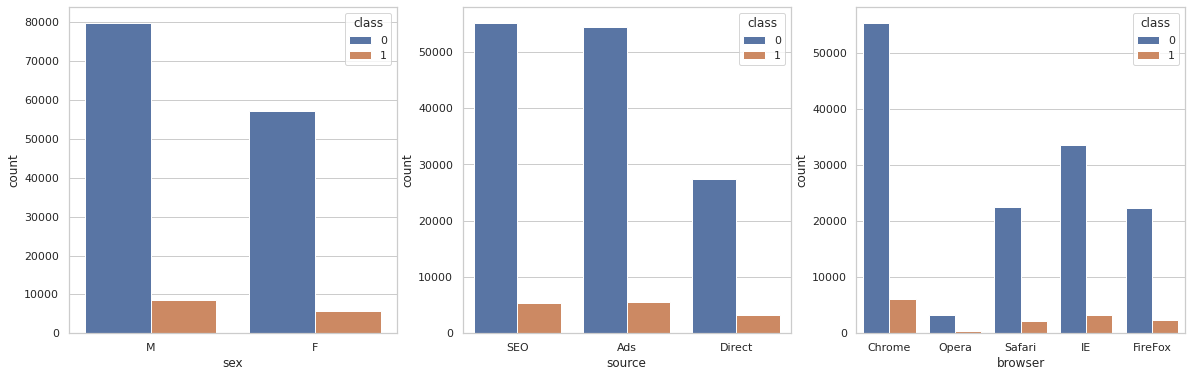

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(131)
sns.countplot(x='sex', hue='class', data=df)

plt.subplot(132)
sns.countplot(x='source', hue='class', data=df)

plt.subplot(133)
sns.countplot(x='browser', hue='class', data=df)

In both cases, each user_id buys only one time.

#Time vs. fraud

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


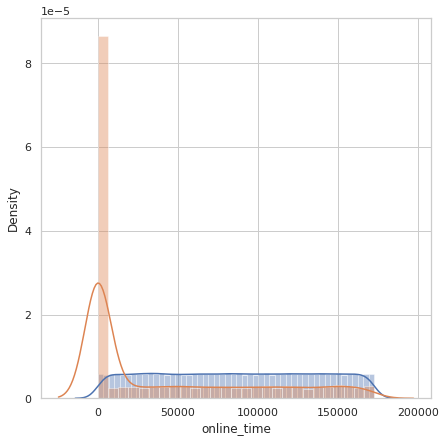

In [22]:
plt.figure(figsize=(7,7))
sns.distplot(df[df['class']==0]['online_time'])
sns.distplot(df[df['class']==1]['online_time'])

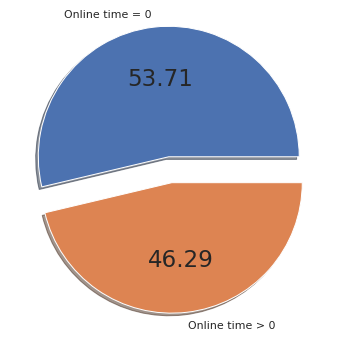

In [ ]:
fraud_at_0 = df[(df['class']==1) & (df['online_time']==0)].shape[0]/df[df['class']==1].shape[0]
#print(fraud_at_0)
fraud_time_online = [fraud_at_0, (1-fraud_at_0)]

plt.figure(figsize=(6,6))
plt.pie(fraud_time_online, explode=(0.1, 0.1), labels=['Online time = 0', 'Online time > 0'], autopct='%.2f', shadow=True, startangle=0)
plt.rc('font', size=20)

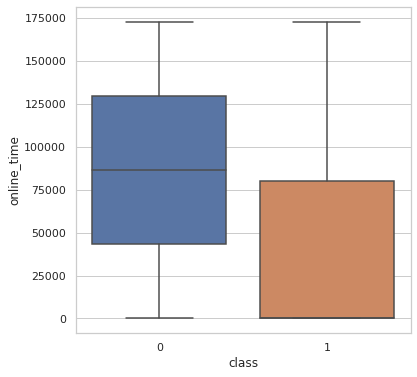

In [ ]:
plt.figure(figsize=(6,6))
sns.boxplot(y='online_time', x='class', data=df)

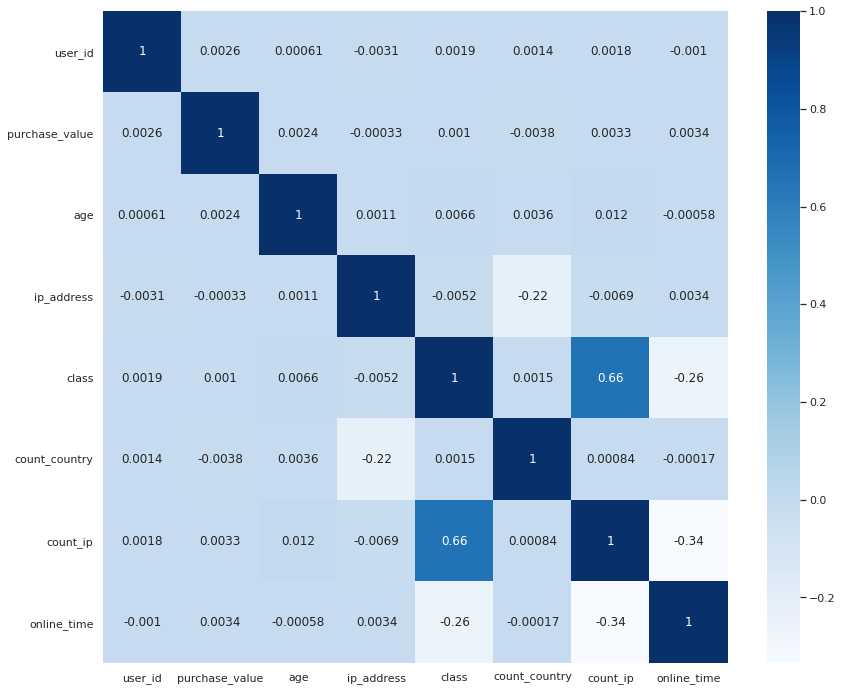

In [ ]:
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(), cmap='Blues', annot=True)
plt.rc('font', size=12)

All purchase with online time in first minute is fraud. There's no reason that someone pays without seeing products. 

## Classification model to predict fraud

In [23]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,count_country,category_country,count_ip,online_time
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,7306,2961_12038,1,75111.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,58049,23810_58049,1,299.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,58049,23810_58049,12,0.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Australia,23810,12038_23810,1,8201.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,58049,23810_58049,1,72691.0


In [24]:
numeric_feats = ['purchase_value', 'age', 'online_time', 'count_ip'] 
categorical_feats = ['source', 'sex', 'browser', 'category_country']
target = ['class']
df_model = df[numeric_feats + categorical_feats + target]

X = df[numeric_feats + categorical_feats]
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Original train set : ', Counter(y_train))
print('Origianel test set : ', Counter(y_test))

#PREPROCESSING
preprocessor = ColumnTransformer(
    transformers = [("scaler", MinMaxScaler(), numeric_feats),
                    ("onehot", OneHotEncoder(), categorical_feats)])
X_train = pd.DataFrame(preprocessor.fit_transform(X_train))
X_test = pd.DataFrame(preprocessor.transform(X_test))

Original train set :  Counter({0: 109568, 1: 11321})
Origianel test set :  Counter({0: 27393, 1: 2830})


The dataset is very imbalanced, so that we should use the class_weight='balanced' in model LogisticRegression and RandomForest. For XGBoost, the parameter is sample_weight, that is defined by the ratio between 2 classes.

In [26]:
sample_weight = y_train.shape[0]/(2*np.bincount(y_train))

models_used = {'LogRegr' : LogisticRegression(n_jobs=-1, class_weight='balanced'),
    'RForest': RandomForestClassifier(n_jobs=-1, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(n_jobs=-1, sample_weight=sample_weight[y_train.values], )}

n_split = 3

param_grid = [{'C': [0.01, 1, 10], 'penalty': ['l1', 'l2']},
               {'n_estimators' : [50, 100], 'criterion': ['gini', 'entropy']},
               {'learning_rate': [0.01, 1, 10], 'n_estimators': [50, 100]}]

In [27]:
%%time
roc_keys = []
roc_values = []
best_estimator = []
for i, (model_name, model, param) in enumerate(zip(models_used.keys(), models_used.values(), param_grid)):
    print(model_name)
    grid = GridSearchCV(model, param, cv=StratifiedKFold(n_split), n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred = pd.DataFrame(grid.predict(X_test))
    y_pred_proba = pd.DataFrame(grid.predict_proba(X_test))
    fpr, tpr, threshold = roc_curve(y_test, y_pred_proba.loc[:,1])

    print(classification_report(y_true=y_test, y_pred=y_pred))
    
    print('Confusion matrix on train set')
    print(confusion_matrix(y_train, grid.predict(X_train)))

    print('Confusion matrix on test set')
    print(confusion_matrix(y_test, y_pred))
    print()

    #Save results
    best_estimator.append(grid.best_estimator_)
    roc_keys.append(model_name)
    roc_values.append((fpr, tpr))

roc_models = dict(zip(roc_keys, roc_values))



LogRegr


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
9 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver l

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     27393
           1       0.91      0.53      0.67      2830

    accuracy                           0.95     30223
   macro avg       0.93      0.76      0.82     30223
weighted avg       0.95      0.95      0.95     30223

Confusion matrix on train set
[[108986    582]
 [  5185   6136]]
Confusion matrix on test set
[[27250   143]
 [ 1333  1497]]

RForest
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       0.98      0.53      0.69      2830

    accuracy                           0.95     30223
   macro avg       0.97      0.76      0.83     30223
weighted avg       0.96      0.95      0.95     30223

Confusion matrix on train set
[[109568      0]
 [    20  11301]]
Confusion matrix on test set
[[27369    24]
 [ 1337  1493]]

XGBoost
              precision    recall  f1-score   support

           0       0.95

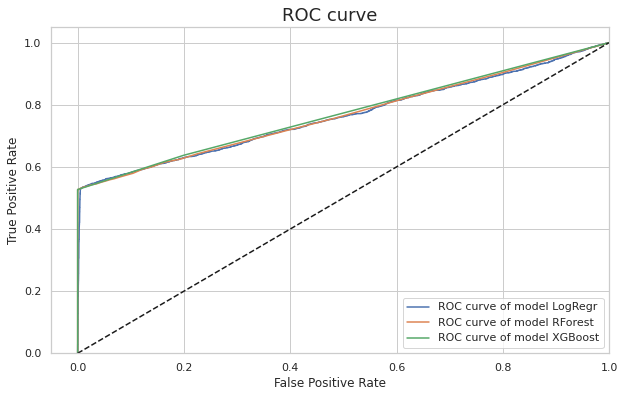

In [28]:
plt.figure(figsize=(10,6))
for key, roc in roc_models.items():
    plt.plot(roc[0], roc[1],
             label='ROC curve of model {}'.format(str(key)))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title( 'ROC curve', fontsize=18)
plt.rc('font', size=15)
plt.show()

In [ ]:
LogReg = best_estimator[0]
RForest = best_estimator[1]
GBoost = best_estimator[2]
final_models = [LogReg, RForest, GBoost]

threshold_list = np.arange(0.3, 1.0, 0.1)

for model in final_models:
    print(model)
    for i in threshold_list:
        print('\n***** For threshold = {} *****'.format(i))
        y_test_pred = pd.DataFrame(model.predict_proba(X_test)).applymap(lambda x: 1 if x>i else 0)

        print(classification_report(y_true=y_test, y_pred=y_test_pred.iloc[:,1]))
        print(confusion_matrix(y_test, y_test_pred.iloc[:,1]))
        print()


LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

***** For threshold = 0.3 *****
              precision    recall  f1-score   support

           0       0.95      0.23      0.38     27393
           1       0.11      0.88      0.19      2830

    accuracy                           0.30     30223
   macro avg       0.53      0.56      0.28     30223
weighted avg       0.87      0.30      0.36     30223

[[ 6419 20974]
 [  332  2498]]


***** For threshold = 0.4 *****
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     27393
           1       0.50      0.56      0.53      2830

    accuracy                           0.91     30223
   macro avg       0.73   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       1.00      0.53      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.98      0.76      0.83     30223
weighted avg       0.96      0.96      0.95     30223

[[27393     0]
 [ 1339  1491]]


***** For threshold = 0.5 *****
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       1.00      0.53      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.98      0.76      0.83     30223
weighted avg       0.96      0.96      0.95     30223

[[27393     0]
 [ 1339  1491]]


***** For threshold = 0.6000000000000001 *****
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       1.00      0.53      0.69      2830

    accuracy                         

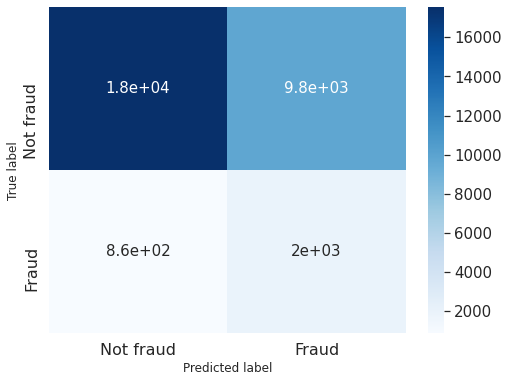

In [ ]:
cm_lr = confusion_matrix(y_test, LogReg.predict(X_test))

plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_lr, annot=True, cmap='Blues')
sns.set(font_scale=1.5)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
ax.set_xticklabels(['Not fraud', 'Fraud'])
ax.set_yticklabels(['Not fraud', 'Fraud'])
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.tick_params(labelsize=16)


In [ ]:
#df_model = df[numeric_feats + categorical_feats + target]

ohe = (preprocessor.named_transformers_['onehot'])

feature_names_ohe = ohe.get_feature_names(input_features=categorical_feats)
print(feature_names_ohe)
print()
feature_names = np.r_[numeric_feats, feature_names_ohe]
feature_names

['source_Ads' 'source_Direct' 'source_SEO' 'sex_F' 'sex_M'
 'browser_Chrome' 'browser_FireFox' 'browser_IE' 'browser_Opera'
 'browser_Safari' 'category_country_1.0_2961.0'
 'category_country_12038.0_23810.0' 'category_country_23810.0_58049.0'
 'category_country_2961.0_12038.0']



array(['purchase_value', 'age', 'online_time', 'source_Ads',
       'source_Direct', 'source_SEO', 'sex_F', 'sex_M', 'browser_Chrome',
       'browser_FireFox', 'browser_IE', 'browser_Opera', 'browser_Safari',
       'category_country_1.0_2961.0', 'category_country_12038.0_23810.0',
       'category_country_23810.0_58049.0',
       'category_country_2961.0_12038.0'], dtype=object)

<Figure size 720x720 with 0 Axes>

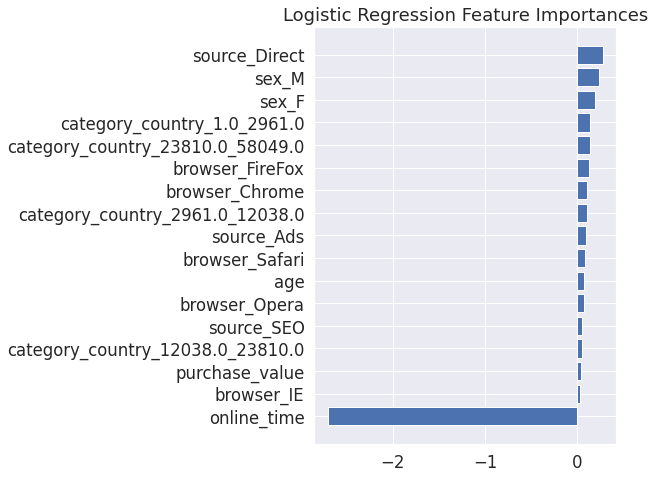

In [ ]:
n = len(feature_names)
LR_feats_importance = LogReg.coef_.ravel()
sorted_idx = np.argsort(LR_feats_importance)[::-1][:n]
feature_names[sorted_idx]

plt.figure(figsize=(10, 10))
y_ticks = np.arange(0, len(feature_names[sorted_idx]))
fig, ax1 = plt.subplots(1, 1, figsize=(9,7))
ax1.barh(y_ticks, LR_feats_importance[sorted_idx])
ax1.set_yticklabels(feature_names[sorted_idx])
ax1.set_yticks(y_ticks)
ax1.invert_yaxis()

ax1.set_title("Logistic Regression Feature Importances")
fig.tight_layout()
sns.set_style(style='white')
plt.show()


Text(-255.685, 0.5, '')

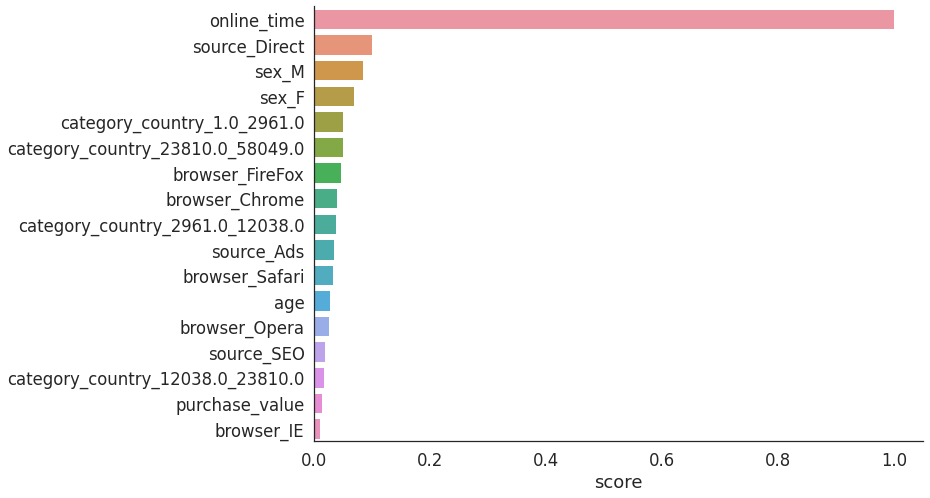

In [ ]:
feats_ranking_LG = pd.DataFrame({'features': feature_names[sorted_idx], 'score': np.abs(LR_feats_importance[sorted_idx]/np.max(abs(LR_feats_importance)))}).sort_values(by='score', ascending=False)
sns.set_style(style='white')
sns.catplot(x='score', y='features', data=feats_ranking_LG, kind="bar", height=7.27, aspect=11.7/6.27)
plt.ylabel('')

XGB : feature importance

Text(-255.685, 0.5, '')

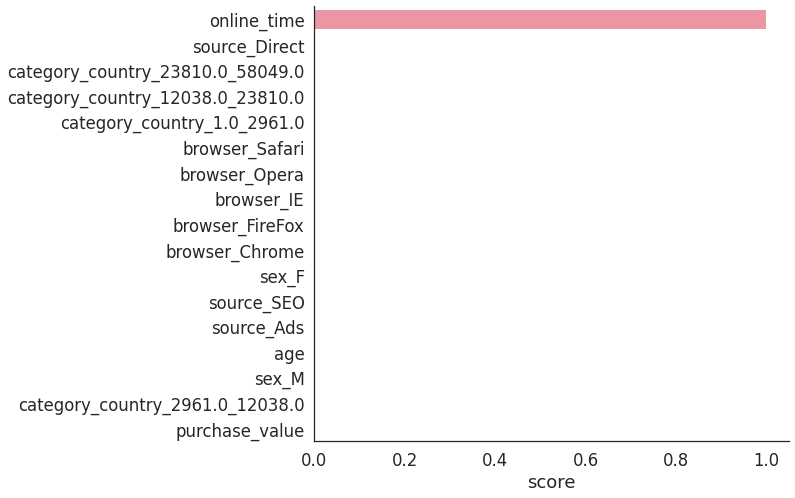

In [ ]:
GB_feats_importance = GBoost.feature_importances_
sorted_GB = np.argsort(GB_feats_importance)[::-1][:n]

feats_ranking_GB = pd.DataFrame({'features': feature_names[sorted_GB], 'score': np.abs(GB_feats_importance[sorted_GB])}).sort_values(by='score', ascending=False)
sns.catplot(x='score', y='features', data=feats_ranking_GB, kind="bar", height=7.27, aspect=11.7/7.27)
plt.ylabel('')

#Test statistique sur l'importance des features

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

X_indices = np.arange(X_train.shape[-1])

selector = SelectKBest(f_classif, k=17)
selector.fit(X_train, y_train)

df_stat_feats = pd.DataFrame({'features':feature_names, 'score': selector.scores_/max(selector.scores_), 'p_value': selector.pvalues_}).sort_values(by='score', ascending=False)
df_stat_feats

,features,score,p_value
2,online_time,1.000000,0.000000e+00
4,source_Direct,0.006715,1.820437e-14
5,source_SEO,0.002634,1.587383e-06
10,browser_IE,0.002580,2.035830e-06
8,browser_Chrome,0.002256,8.920602e-06
14,category_country_12038.0_23810.0,0.001371,5.340155e-04
6,sex_F,0.000672,1.532150e-02
7,sex_M,0.000672,1.532150e-02
15,category_country_23810.0_58049.0,0.000533,3.084155e-02
1,age,0.000480,4.046387e-02


Select feature with p_value < 10%

In [ ]:
feature_selected = ['online_time', 'source_Direct', 'source_SEO', 'browser_IE', 'browser_Chrome',
                    'category_country_12038.0_23810.0', 'sex_F', 'sex_M', 'category_country_23810.0_58049.0', 'age' ]

X_train_feature_selected = pd.DataFrame(X_train.values, columns=feature_names)[feature_selected]
X_test_feature_selected = pd.DataFrame(X_test.values, columns=feature_names)[feature_selected]

In [ ]:
%%time
roc_keys = []
roc_values = []
best_estimator = []
for i, (model_name, model, param) in enumerate(zip(models_used.keys(), models_used.values(), param_grid)):
    print(model_name)
    grid = GridSearchCV(model, param, cv=StratifiedKFold(n_split), n_jobs=-1)
    grid.fit(X_train_feature_selected, y_train)

    y_pred = pd.DataFrame(grid.predict(X_test_feature_selected))
    y_pred_proba = pd.DataFrame(grid.predict_proba(X_test_feature_selected))
    fpr, tpr, threshold = roc_curve(y_test, y_pred_proba.loc[:,1])

    print(classification_report(y_true=y_test, y_pred=y_pred))
    
    print('Confusion matrix on train set')
    print(confusion_matrix(y_train, grid.predict(X_train_feature_selected)))

    print('Confusion matrix on test set')
    print(confusion_matrix(y_test, y_pred))
    print()

    #Save results
    best_estimator.append(grid.best_estimator_)
    roc_keys.append(model_name)
    roc_values.append((fpr, tpr))

roc_models_feature_selected = dict(zip(roc_keys, roc_values))


LogRegr
              precision    recall  f1-score   support

           0       0.95      0.64      0.77     27393
           1       0.17      0.70      0.27      2830

    accuracy                           0.65     30223
   macro avg       0.56      0.67      0.52     30223
weighted avg       0.88      0.65      0.72     30223

Confusion matrix on train set
[[70653 38915]
 [ 3335  7986]]
Confusion matrix on test set
[[17541  9852]
 [  863  1967]]

RForest
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     27393
           1       0.78      0.53      0.63      2830

    accuracy                           0.94     30223
   macro avg       0.87      0.76      0.80     30223
weighted avg       0.94      0.94      0.94     30223

Confusion matrix on train set
[[109567      1]
 [   150  11171]]
Confusion matrix on test set
[[26968   425]
 [ 1320  1510]]

XGBoost
              precision    recall  f1-score   support

           0       

In [ ]:
plt.figure(figsize=(10,6))
for key, roc in roc_models.items():
    plt.plot(roc[0], roc[1],
             label='ROC curve of model {}'.format(str(key)))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title( 'ROC curve - feature selected', fontsize=18)
plt.rc('font', size=15)
plt.show()

#PCA

In [ ]:
pca = PCA(n_components=9)
pca_result  = pd.DataFrame(pca.fit_transform(df_train.drop(['class'], axis=1)))
print('Total inerties inlus in PCA : ', np.sum(pca.explained_variance_ratio_))

df_train['pca-one'] = pca_result.loc[:,0]
df_train['pca-two'] = pca_result.loc[:,1] 
df_train['pca-three'] = pca_result.loc[:,2]
df_train['pca-four'] = pca_result.loc[:,3]
df_train['pca-five'] = pca_result.loc[:,4]


Total inerties inlus in PCA :  0.9645832471740058


In [ ]:
df_pca = df_train[['pca-one', 'pca-two', 'pca-three', 'pca-four', 'pca-five', 'class']]

Train with 20000 non-fraud cases and 11 321 fraud cases

In [ ]:
non_fraud = df_pca[df_pca['class'] == 0].sample(20000)
fraud = df_pca[df_pca['class'] == 1]

df_pca_clf = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X_pca_clf = df_pca_clf.drop(['class'], axis = 1).values
y_pca_clf = df_pca_clf["class"].values

Counter(y_pca_clf)

Counter({0: 20000, 1: 11321})

In [ ]:
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca_clf, y_pca_clf, test_size=0.2, stratify=y_pca_clf, random_state=42)
print(Counter(y_pca_train))
print(Counter(y_pca_test))

Counter({0: 15999, 1: 9057})
Counter({0: 4001, 1: 2264})


In [ ]:
%%time
roc_keys = []
roc_values = []
best_estimator = []
for i, (model_name, model, param) in enumerate(zip(models_used.keys(), models_used.values(), param_grid)):
    print(model_name)
    grid = GridSearchCV(model, param, cv=StratifiedKFold(n_split), n_jobs=-1)
    grid.fit(X_pca_train, y_pca_train)

    y_pca_pred = pd.DataFrame(grid.predict(X_pca_test))
    y_pca_pred_proba = pd.DataFrame(grid.predict_proba(X_pca_test))
    fpr, tpr, threshold = roc_curve(y_pca_test, y_pca_pred_proba.loc[:,1])

    print(classification_report(y_true=y_pca_test, y_pred=y_pca_pred))
    print(confusion_matrix(y_pca_test, y_pca_pred))
    print()

    #Save results
    best_estimator.append(grid.best_estimator_)
    roc_keys.append(model_name)
    roc_values.append((fpr, tpr))

roc_pca_models = dict(zip(roc_keys, roc_values))

LogRegr
              precision    recall  f1-score   support

           0       0.66      0.55      0.60      4001
           1       0.39      0.50      0.44      2264

    accuracy                           0.53      6265
   macro avg       0.52      0.52      0.52      6265
weighted avg       0.56      0.53      0.54      6265

[[2191 1810]
 [1128 1136]]

RForest
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      4001
           1       0.81      0.56      0.66      2264

    accuracy                           0.79      6265
   macro avg       0.80      0.74      0.76      6265
weighted avg       0.79      0.79      0.78      6265

[[3694  307]
 [ 993 1271]]

XGBoost
              precision    recall  f1-score   support

           0       0.78      0.94      0.86      4001
           1       0.84      0.55      0.66      2264

    accuracy                           0.80      6265
   macro avg       0.81      0.74      0.76     

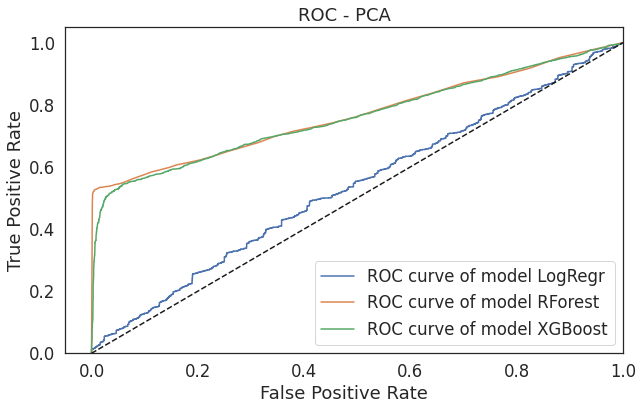

In [ ]:
plt.figure(figsize=(10,6))
for key, roc in roc_pca_models.items():
    plt.plot(roc[0], roc[1],
             label='ROC curve of model {}'.format(str(key)))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title( 'ROC - PCA', fontsize=18)
plt.rc('font', size=15)
plt.show()

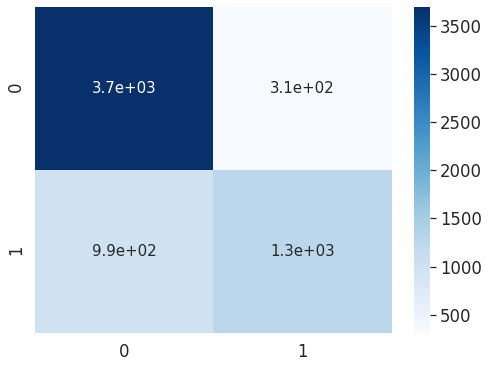

In [ ]:
plt.figure(figsize=(8,6))
cm_pca = confusion_matrix(y_pca_test, best_estimator[1].predict(X_pca_test))
sns.heatmap(cm_pca, annot=True, cmap='Blues')

# Visualization with t-SNE

t_SNE

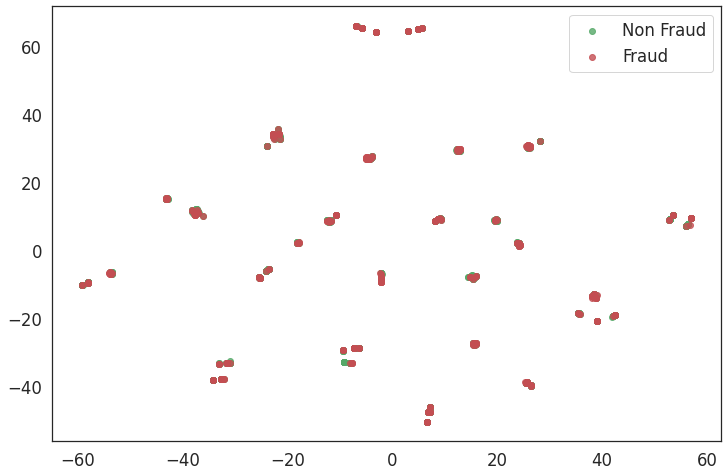

In [ ]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(X_pca_train[:1000], y_pca_train[:1000], "original.png")

#Autoencoder

In [ ]:
X_norm = X_pca_train[y_pca_train==0]
X_fraud = X_pca_train[y_pca_train==1]

In [ ]:
X_norm.shape

(15999, 5)

In [ ]:
X_fraud.shape

(9057, 5)

In [ ]:
# input layer
input_layer = Input(shape=(X_norm.shape[1],))

#encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

#decoding part 
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

#output layer 
output_layer = Dense(X_norm.shape[1], activation='softmax')(decoded)

In [ ]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adadelta', loss='mse')

In [ ]:
autoencoder.fit(X_norm[0:10000], X_norm[0:10000],
                batch_size=256, epochs=30, 
                shuffle=True, validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/30
8000/8000 [==============================] - 0s 46us/step - loss: 1.0426 - val_loss: 0.8631
Epoch 2/30
8000/8000 [==============================] - 0s 11us/step - loss: 0.7867 - val_loss: 0.7074
Epoch 3/30
8000/8000 [==============================] - 0s 12us/step - loss: 0.6495 - val_loss: 0.5905
Epoch 4/30
8000/8000 [==============================] - 0s 10us/step - loss: 0.5596 - val_loss: 0.5372
Epoch 5/30
8000/8000 [==============================] - 0s 10us/step - loss: 0.5281 - val_loss: 0.5195
Epoch 6/30
8000/8000 [==============================] - 0s 10us/step - loss: 0.5188 - val_loss: 0.5031
Epoch 7/30
8000/8000 [==============================] - 0s 10us/step - loss: 0.5126 - val_loss: 0.5046
Epoch 8/30
8000/8000 [==============================] - 0s 10us/step - loss: 0.5090 - val_loss: 0.5004
Epoch 9/30
8000/8000 [==============================] - 0s 10us/step - loss: 0.5058 - val_loss: 0.4960
Epoch 10/30
8000/8000 [==

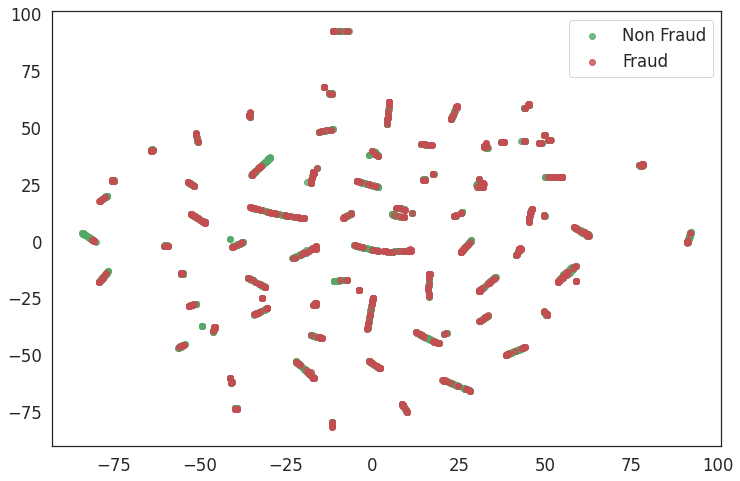

In [ ]:
norm_hid_rep_tSNE = autoencoder.predict(X_norm[:2500])
fraud_hid_rep_tSNE = autoencoder.predict(X_fraud[:1000])
rep_x = np.append(norm_hid_rep_tSNE, fraud_hid_rep_tSNE, axis = 0)
y_n = np.zeros(norm_hid_rep_tSNE.shape[0])
y_f = np.ones(fraud_hid_rep_tSNE.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")


In [ ]:
norm_hid_rep = autoencoder.predict(X_norm[10000:])
fraud_hid_rep = autoencoder.predict(X_fraud)
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

In [ ]:
%%time
X_train_autoen, X_test_autoen, y_train_autoen, y_test_autoen = train_test_split(rep_x, rep_y, test_size=0.25)

roc_keys = []
roc_values = []
best_estimator = []
for i, (model_name, model, param) in enumerate(zip(models_used.keys(), models_used.values(), param_grid)):
    print(model_name)
    grid = GridSearchCV(model, param, cv=StratifiedKFold(n_split), n_jobs=-1)
    grid.fit(X_train_autoen, y_train_autoen)

    y_autoencoder_pred = pd.DataFrame(grid.predict(X_test_autoen))
    y_autoencoder_pred_proba = pd.DataFrame(grid.predict_proba(X_test_autoen))
    fpr, tpr, threshold = roc_curve(y_test_autoen, y_autoencoder_pred_proba.loc[:,1])

    print(classification_report(y_true=y_pca_test, y_pred=y_pca_pred))
    print(confusion_matrix(y_test_autoen, y_autoencoder_pred))
    print()

    #Save results
    best_estimator.append(grid.best_estimator_)
    roc_keys.append(model_name)
    roc_values.append((fpr, tpr))

roc_autoencoder_models = dict(zip(roc_keys, roc_values))

LogRegr
              precision    recall  f1-score   support

           0       0.78      0.94      0.86      4001
           1       0.84      0.55      0.66      2264

    accuracy                           0.80      6265
   macro avg       0.81      0.74      0.76      6265
weighted avg       0.80      0.80      0.78      6265

[[ 732  691]
 [1141 1200]]

RForest
              precision    recall  f1-score   support

           0       0.78      0.94      0.86      4001
           1       0.84      0.55      0.66      2264

    accuracy                           0.80      6265
   macro avg       0.81      0.74      0.76      6265
weighted avg       0.80      0.80      0.78      6265

[[ 913  510]
 [ 680 1661]]

XGBoost
              precision    recall  f1-score   support

           0       0.78      0.94      0.86      4001
           1       0.84      0.55      0.66      2264

    accuracy                           0.80      6265
   macro avg       0.81      0.74      0.76     

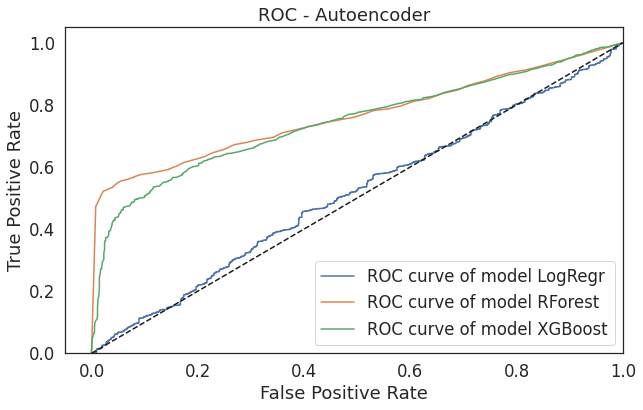

In [ ]:
plt.figure(figsize=(10,6))
for key, roc in roc_autoencoder_models.items():
    plt.plot(roc[0], roc[1],
             label='ROC curve of model {}'.format(str(key)))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title( 'ROC - Autoencoder', fontsize=18)
plt.rc('font', size=15)
plt.show()

In [ ]:
LogReg = best_estimator[0]
RForest = best_estimator[1]
GBoost = best_estimator[2]
final_models = [LogReg, RForest, GBoost]

threshold_list = np.arange(0.3, 1.0, 0.1)

for model in final_models:
    print(model)
    for i in threshold_list:
        print('\n***** For threshold = {} *****'.format(i))
        y_test_pred = pd.DataFrame(model.predict_proba(X_test_autoen)).applymap(lambda x: 1 if x>i else 0)

        print(classification_report(y_true=y_test_autoen, y_pred=y_test_pred.iloc[:,1]))
        print(confusion_matrix(y_test_autoen, y_test_pred.iloc[:,1]))
        print()

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

***** For threshold = 0.3 *****
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1423
         1.0       0.62      1.00      0.77      2341

    accuracy                           0.62      3764
   macro avg       0.31      0.50      0.38      3764
weighted avg       0.39      0.62      0.48      3764

[[   0 1423]
 [   0 2341]]


***** For threshold = 0.4 *****
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1423
         1.0       0.62      1.00      0.77      2341

    accuracy                           0.62      3764
   macro avg       0.31      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classificat

[[1423    0]
 [2341    0]]


***** For threshold = 0.9000000000000001 *****
              precision    recall  f1-score   support

         0.0       0.38      1.00      0.55      1423
         1.0       0.00      0.00      0.00      2341

    accuracy                           0.38      3764
   macro avg       0.19      0.50      0.27      3764
weighted avg       0.14      0.38      0.21      3764

[[1423    0]
 [2341    0]]

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

***** For threshol

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.56      0.51      0.53      1423
         1.0       0.72      0.76      0.74      2341

    accuracy                           0.66      3764
   macro avg       0.64      0.63      0.64      3764
weighted avg       0.66      0.66      0.66      3764

[[ 720  703]
 [ 562 1779]]


***** For threshold = 0.5 *****
              precision    recall  f1-score   support

         0.0       0.57      0.64      0.61      1423
         1.0       0.77      0.71      0.74      2341

    accuracy                           0.68      3764
   macro avg       0.67      0.68      0.67      3764
weighted avg       0.69      0.68      0.69      3764

[[ 913  510]
 [ 680 1661]]


***** For threshold = 0.6000000000000001 *****
              precision    recall  f1-score   support

         0.0       0.57      0.75      0.65      1423
         1.0       0.81      0.66      0.73      2341

    accuracy                           0.69  

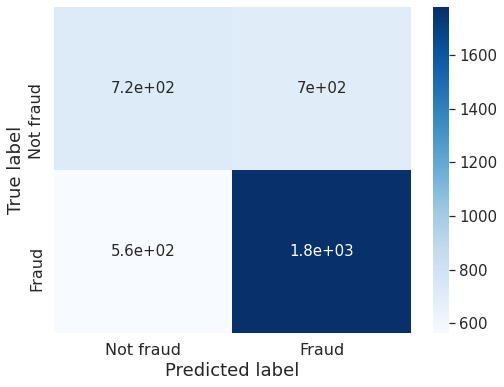

In [ ]:
#Take threshold = 0.4 for Random Forest 

RF_autoencoder = best_estimator[1]
threshold_taken = 0.40
y_test_autoencoder_pred = pd.DataFrame(RF_autoencoder.predict_proba(X_test_autoen)).applymap(lambda x: 1 if x > threshold_taken else 0)

cm_FR_autoencoder = confusion_matrix(y_test_autoen, y_test_autoencoder_pred.iloc[:,1])

plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_FR_autoencoder, annot=True, cmap='Blues')
sns.set(font_scale=1.5)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
ax.set_xticklabels(['Not fraud', 'Fraud'])
ax.set_yticklabels(['Not fraud', 'Fraud'])
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.tick_params(labelsize=16)